In [16]:
#%matplotlib notebook
%matplotlib inline
from traceback import print_exc
import json
from collections import defaultdict
import dateutil.parser
from matplotlib import pylab
import numpy as np
base = 'output/'
docfile = open(base+'documents.json','rb')
documents = []
regions = json.load(open('output/regions.json','rb'))
hosts = defaultdict(list) # host:docs
categories = defaultdict(lambda: defaultdict(int)) # host:cat:num

history = defaultdict(lambda: defaultdict(lambda: defaultdict(int))) # host:cat:year:num
general_history = defaultdict(lambda: defaultdict(int)) # cat:year:num
years = set([])
by_region = defaultdict(lambda: defaultdict(int)) # region:cat:n
by_province = defaultdict(lambda: defaultdict(int)) # province:cat:n
by_cap =  defaultdict(lambda: defaultdict(int)) # cap:cat:n
overall = defaultdict(int) #cat:num
noyear = 0

def incr_category(h,c,y):
    global noyear
    overall[c]+=1
    categories[h][c]+=1
    by_region[doc['region']][c]+=1
    by_province[doc['prov']][c]+=1
    by_cap[doc['cap']][c]+=1
    if y:
        history[h][c][y]+=1
        general_history[c][y]+=1
        years.add(y)
    else:
        noyear+=1

archieved = []
sizes = defaultdict(int)
size_by_type = defaultdict(lambda: defaultdict(int))
for i,docline in enumerate(docfile):
    try:
        doc = json.loads(docline)
    except:
        print_exc()
        print(i,docline)
        continue
    documents.append(doc)
    h = doc['host']
    c = doc['category']
    size = doc['size']
    if c in ('archive',): #, 'pdf'):
        continue
    
    if doc.get('archive_path'): # and c!='pdf':
        archieved.append(doc)
        size = 0
    hosts[h].append(doc)
    y = doc['latest'] or 0
    d = 0
    if y:
        y = dateutil.parser.parse(y).year
    if y<1990 or y>2021:
        if 'pubDate' in doc:
            y = dateutil.parser.parse(doc['pubDate']).year
    if y<1990 or y>2021:
        y = 0
    
    
    
    if c not in ('archive',): #'pdf'
        sizes[y]+= size
        size_by_type[c][y] += size
        incr_category(h,c,y)
        
print('Documents',len(documents))
print('Missing date:',noyear)
print('Extracted from archives:',len(archieved))
years = sorted(list(years))
general_proportions = defaultdict(list) #cat:[%] per years
count_history = []
for y in years:
    cat = {} #cat:num in this year
    tot = 0 # total in this year
    for c,yn in general_history.items():
        cat[c] = yn[y]
        tot+=cat[c]
    count_history.append(tot)
    for c,n in cat.items():
        general_proportions[c].append(100.*n/tot)
        
json.dump(general_proportions, open(base+'national_share.json','w'))

# Total docs by host
host_index = np.array(list(hosts.keys()))
total_documents = np.array([len(hosts[h]) for h in host_index])

# opendocument share index
opendocument_share = np.zeros(len(hosts)) 

for i,h in enumerate(host_index):
    tot = sum(categories[h].values())
    for c,val in categories[h].items():
        categories[h][c] = 100.*val/tot
    opendocument_share[i] = int(categories[h]['opendocument'])

# Sort by share, then by total
oi = np.lexsort((1/(total_documents+1), opendocument_share))
oi2 = np.lexsort((total_documents, opendocument_share))
on = np.where(opendocument_share[oi]>50)[0][0]

host_index = np.concatenate((host_index[oi[:on]],host_index[oi2[on:]]))
opendocument_share = np.concatenate((opendocument_share[oi[:on]],opendocument_share[oi2[on:]]))
    
print('Hosts',len(hosts))
print(overall)

Documents 288046
Missing date: 14428
Extracted from archives: 41924
Hosts 4867
defaultdict(<class 'int'>, {'msoffice': 84618, 'msofficexml': 109800, 'opendocument': 28558, 'richtext': 21719, 'ooxml': 63})


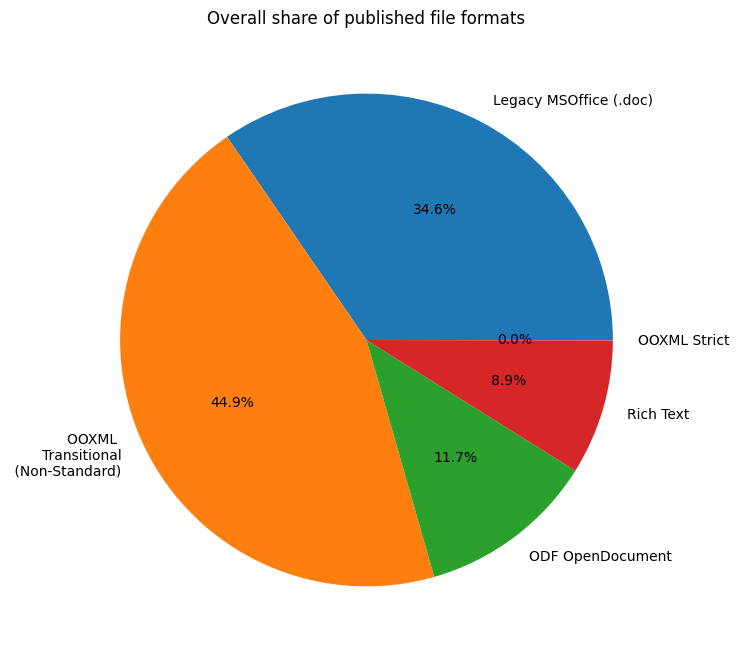

In [14]:
pylab.figure(figsize=(8,8))
labels = {'msoffice':'Legacy MSOffice (.doc)', 
          'msofficexml': 'OOXML \nTransitional\n (Non-Standard)',
          'richtext': 'Rich Text',
          'ooxml': 'OOXML Strict',
         'opendocument':'ODF OpenDocument',
          'pdf':'PDF',
         }
pylab.pie(list(overall.values()),labels=list(map(lambda k: labels[k],overall.keys())), autopct='%.1f%%')
foo=pylab.title('Overall share of published file formats')
pylab.savefig('overall_format_share')

Text(0, 0.5, 'Published data (GB)')

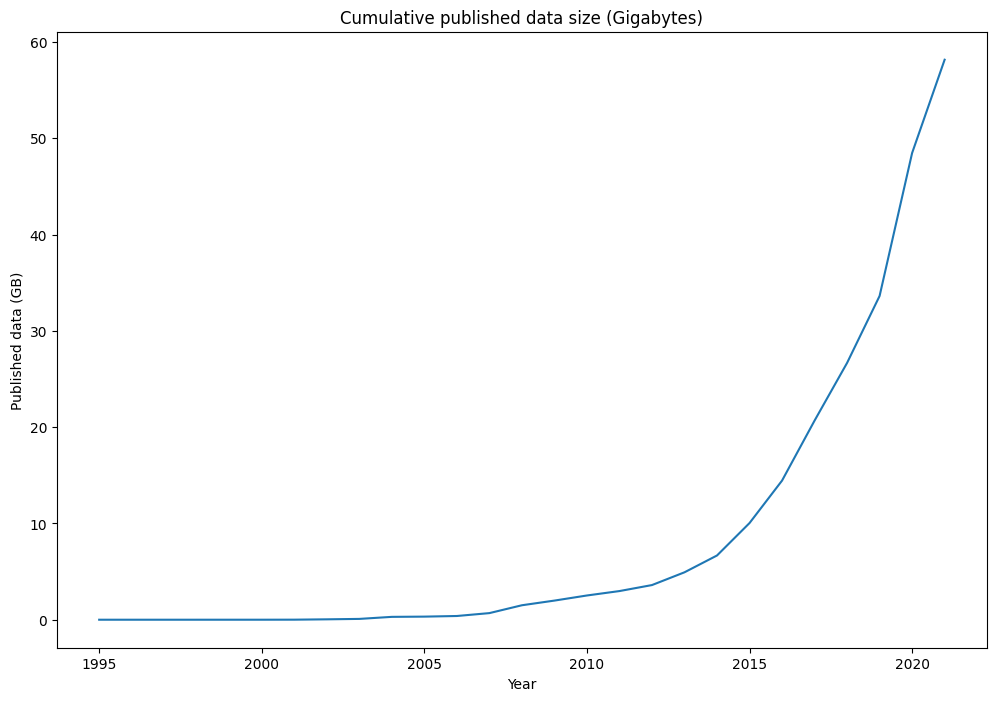

In [15]:
pylab.figure(figsize=(12,8))
pylab.plot(years[0:], np.cumsum([sizes[y]/(10**9) for y in years[0:]]))
pylab.title('Cumulative published data size (Gigabytes)')
pylab.xlabel('Year')
pylab.ylabel('Published data (GB)')

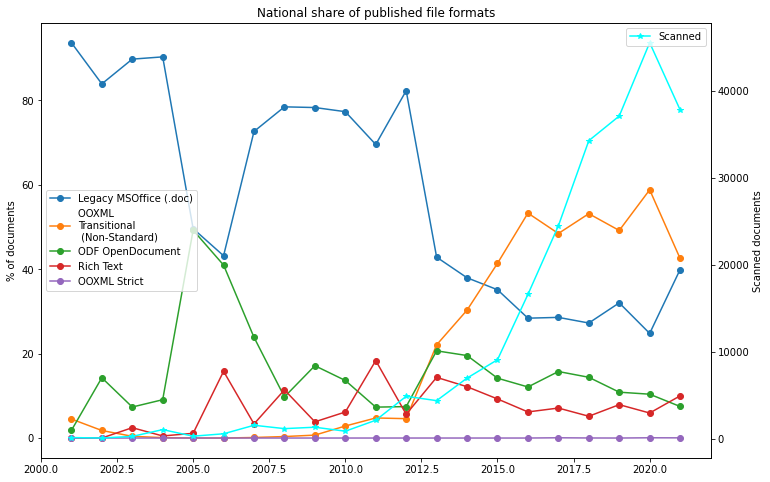

In [6]:
#pylab.figure()
fig,ax = pylab.subplots(figsize=[12,8])
pylab.title('National share of published file formats')
count_history = np.array(count_history)
years = np.array(years)

s = slice(1,None)
m = count_history[s]>50
#s=slice(None,None)
for cat,vals in general_proportions.items():
    ax.plot(years[s][m],np.array(vals)[s][m],'-o',label=labels[cat])
ax.set_ylabel('% of documents')
ax.legend(loc=6)

ax1 = ax.twinx()
ax1.plot(list(years[s][m]),count_history[s][m],'-*',color='cyan',label='Scanned')
ax1.set_ylabel('Scanned documents')
ax1.legend(loc=1)

pylab.savefig('format_share_evolution')



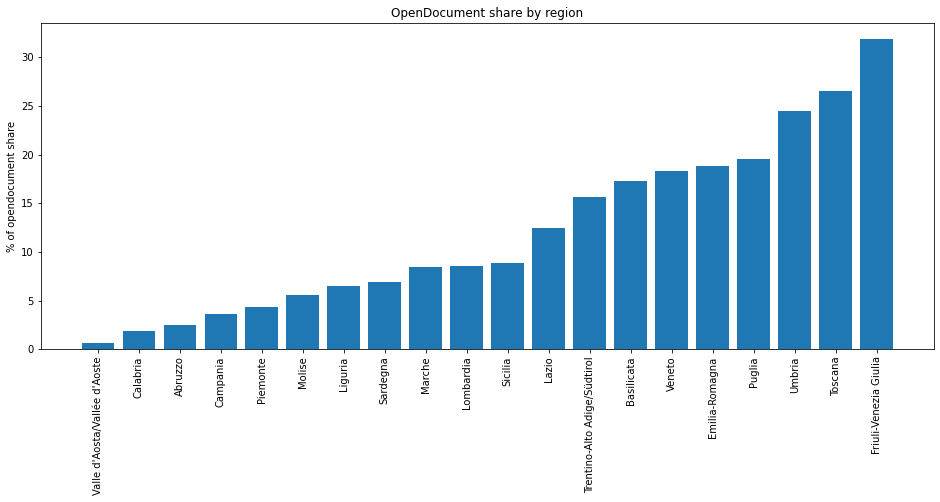

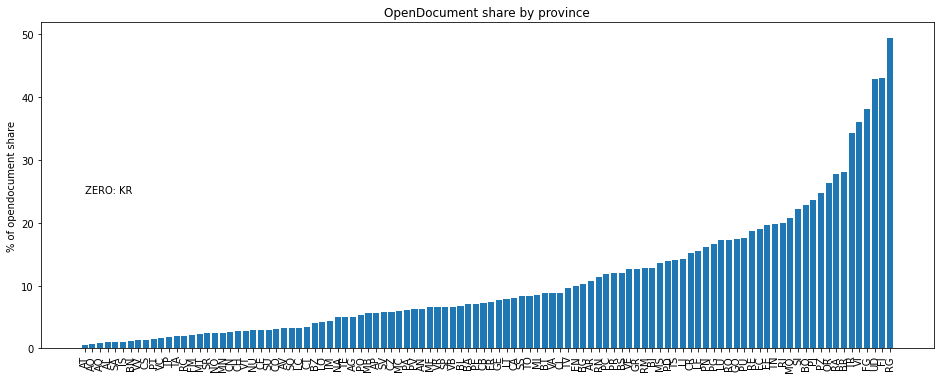

In [5]:
def percent_shares(by_location):
    names = np.array(list(by_location.keys()))
    shares = np.zeros(len(names))
    new = {}
    for i,(r, cat) in enumerate(by_location.items()):
        n = sum(cat.values())
        for c,v in cat.items():
            cat[c]=100.*v/n
        new[r]=cat
        shares[i] = cat['opendocument']
    return new,names,shares

import textwrap

def share_plot(by_location,label):
    out, names, shares = percent_shares(by_location)
    json.dump(out, open(base+label+'_share.json','w'))
    m = shares>0
    order = np.argsort(shares[m])
    pylab.figure(figsize=(16,6))
    pylab.bar(names[m][order], shares[m][order])
    pylab.xticks(rotation = 90)
    pylab.title('OpenDocument share by '+label)
    pylab.ylabel('% of opendocument share')
    z = shares==0
    if sum(z):
        z = textwrap.wrap(', '.join(list(map(str, names[z]))))
        z = '\n      '.join(z)
        pylab.text(0,max(shares)/2,'ZERO: '+z)
    return [(names[m][i],sh) for i,sh in enumerate(shares[m])]
    
odf_by_region = share_plot(by_region,'region')
odf_by_province = share_plot(by_province,'province')

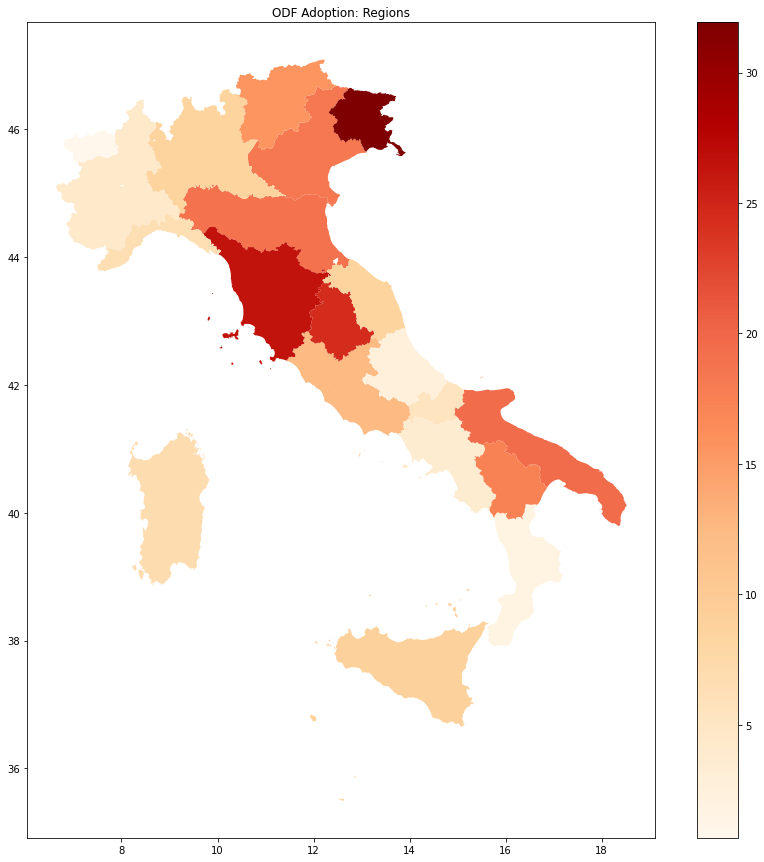

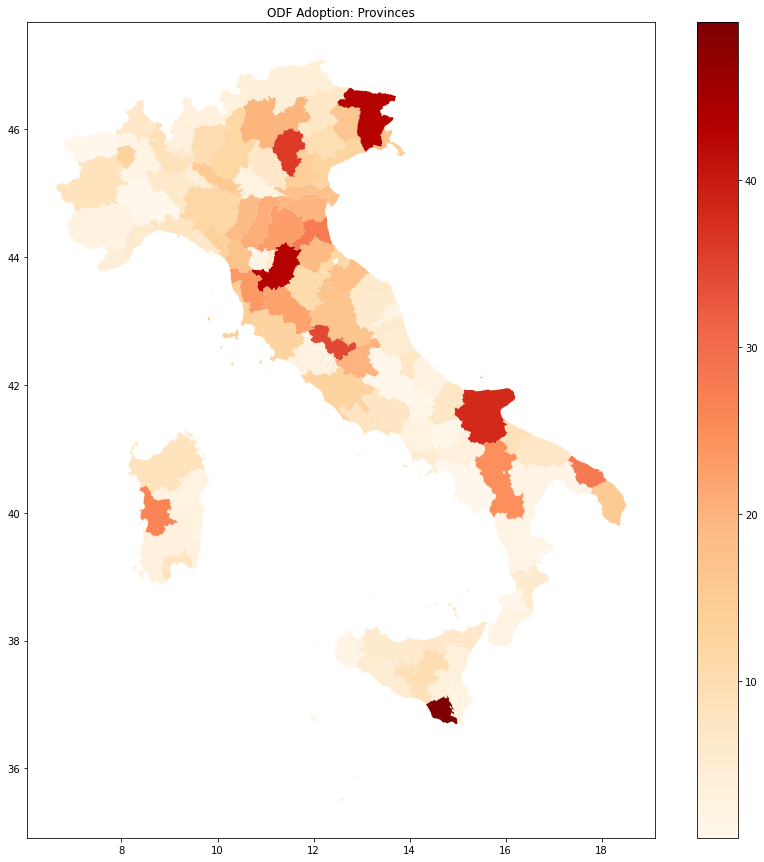

In [6]:
import pandas as pd
import geopandas as gpd
def geomap(geo='regions', odf=odf_by_region):
    col ='reg_name' if geo=='regions' else 'prov_acr'
    data = pd.DataFrame(odf, columns=[col,'odf'])
    mapdat = gpd.read_file('limits_IT_{}.geojson'.format(geo))
    mapdat = mapdat.merge(data, on=col, how='right')
    fig, ax = pylab.subplots(1, figsize=(15, 15))
    ax.set_title('ODF Adoption: '+geo.capitalize())
    mapdat.plot(ax=ax, column='odf', cmap='OrRd',
        legend=True,
        categorical=False)

geomap('regions', odf_by_region)
geomap('provinces', odf_by_province)


In [7]:
# Convert categories by host into %
N = len(documents)

bestfile = open(base+'best_hosts.csv','w')
def printhost(i):
    h = host_index[i]
    n =len(hosts[h])
    m ='{:.0f}%;\t {};\t {:.2f};\t {}'.format(opendocument_share[i], n,100*n/N, h)
    bestfile.write(m+'\n')
    print(m)

print('# BEST HOSTS')
m = '# Share%; N docs; %  over total scanned; host'
bestfile.write(m+'\n')
print(m)
for i in range(-1,-len(hosts),-1):
    printhost(i)
    
bestfile.close()


# BEST HOSTS
# Share%; N docs; %  over total scanned; host
100%;	 68;	 0.02;	 www.liceofermipadova.gov.it
100%;	 49;	 0.02;	 chabod.scuole.vda.it
100%;	 31;	 0.01;	 www.liceogalileilamezia.edu.it
100%;	 21;	 0.01;	 www.comune.montespertoli.fi.it
100%;	 21;	 0.01;	 www.comune.mondovi.cn.it
100%;	 21;	 0.01;	 comune.mondovi.cn.it
100%;	 21;	 0.01;	 www.polizialocalenevi.it
100%;	 18;	 0.01;	 www.iissbojano.edu.it
100%;	 14;	 0.00;	 www.cesanamalanotti.it
100%;	 12;	 0.00;	 www.icmanin.edu.it
100%;	 12;	 0.00;	 www.comune.sedini.ss.it
100%;	 11;	 0.00;	 www.liceopoppi.it
100%;	 9;	 0.00;	 www.sds.zonapisana.it
100%;	 8;	 0.00;	 www.umavc.it
100%;	 6;	 0.00;	 www.icnaro.edu.it
100%;	 5;	 0.00;	 www.comunebarberino.it
100%;	 4;	 0.00;	 www.istitutocomprensivoala.it
100%;	 4;	 0.00;	 www.comune.osasio.to.it
100%;	 4;	 0.00;	 consiglio.regione.umbria.it
100%;	 4;	 0.00;	 iccicagna.edu.it
100%;	 4;	 0.00;	 www.iccicagna.edu.it
100%;	 3;	 0.00;	 www.comune.illasi.vr.it
100%;	 3;	 0.00;	 www.com

0%;	 8;	 0.00;	 www.iiscardano.edu.it
0%;	 8;	 0.00;	 icguarnaccia.edu.it
0%;	 8;	 0.00;	 www.comune.san-leo.rn.it
0%;	 8;	 0.00;	 www.iccollodi.edu.it
0%;	 8;	 0.00;	 www.comune.sanbellino.ro.it
0%;	 8;	 0.00;	 www.comune.fontanelice.bo.it
0%;	 8;	 0.00;	 ordineingap.it
0%;	 8;	 0.00;	 www.corinaldo.it
0%;	 8;	 0.00;	 www.puecherolivetti.edu.it
0%;	 8;	 0.00;	 www.ingbz.it
0%;	 8;	 0.00;	 www.cec-cuneo.it
0%;	 8;	 0.00;	 stroch.scuole.vda.it
0%;	 8;	 0.00;	 www.port.venice.it
0%;	 8;	 0.00;	 www.comune.lusciano.ce.it
0%;	 8;	 0.00;	 agronomiforestalipalermo.it
0%;	 8;	 0.00;	 www.comune.scalenghe.to.it
0%;	 8;	 0.00;	 www.ssp-schlanders.it
0%;	 8;	 0.00;	 www.consulentidellavoro.po.it
0%;	 8;	 0.00;	 www.unionecollinareroero.it
0%;	 8;	 0.00;	 www.consulentidellavoro.ar.it
0%;	 8;	 0.00;	 www.comune.santacrocedelsannio.bn.it
0%;	 8;	 0.00;	 www.comune.gurro.vb.it
0%;	 8;	 0.00;	 www.iiscanova.it
0%;	 8;	 0.00;	 www.icterredelreno.edu.it
0%;	 8;	 0.00;	 www.luxemburg.bo.it
0%;	 8;	 0.0

0%;	 115;	 0.04;	 www.comune.borgosesia.vc.it
0%;	 116;	 0.04;	 www.comune.casalcermelli.al.it
0%;	 116;	 0.04;	 www.comuneassoro.gov.it
0%;	 116;	 0.04;	 www.csac-cn.it
0%;	 116;	 0.04;	 www.favagioia.edu.it
0%;	 117;	 0.04;	 www.halleyweb.com
0%;	 117;	 0.04;	 www.liceimazzinilocri.edu.it
0%;	 118;	 0.04;	 www.icspiandelbruscolo.edu.it
0%;	 118;	 0.04;	 www.itiscassino.edu.it
0%;	 118;	 0.04;	 www.istitutocomprensivo1ortona.edu.it
0%;	 118;	 0.04;	 protezionecivile.regione.emilia-romagna.it
0%;	 119;	 0.04;	 www.fermimontesarchio.edu.it
0%;	 120;	 0.04;	 www.comune.genola.cn.it
0%;	 121;	 0.04;	 comune.montevidoncorrado.fm.it
0%;	 122;	 0.04;	 www.iissgravina.it
0%;	 123;	 0.04;	 www.comune.adrano.ct.it
0%;	 123;	 0.04;	 www.comunetioneditrento.it
0%;	 124;	 0.04;	 www.comune.albidona.cs.it
0%;	 125;	 0.04;	 www.comune.druento.to.it
0%;	 125;	 0.04;	 comune.bagheria.pa.it
0%;	 125;	 0.04;	 www.liceobanfi.edu.it
0%;	 126;	 0.04;	 www.comune.cursi.le.it
0%;	 127;	 0.04;	 www.comune.cas